In [67]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [68]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [69]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [70]:
dog_image_id = os.listdir('images/dogs')[0]
dog_image = load_image(os.path.join('images/dogs',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[4.36659121e-07, 1.11388598e-09, 1.92740213e-10, 3.77740239e-09,
        5.01483166e-09, 6.93450675e-09, 1.34563904e-09, 3.15141557e-09,
        1.03552267e-09, 5.28555366e-10, 1.49172996e-09, 1.75759511e-11,
        1.37203221e-10, 1.10164600e-09, 1.08144681e-10, 3.96392502e-10,
        2.52174082e-09, 9.60064250e-11, 2.70887562e-10, 1.49863433e-09,
        8.59928309e-11, 1.64822336e-10, 1.08919870e-11, 2.83929963e-10,
        3.45894224e-09, 1.32003186e-10, 4.36817826e-09, 9.77929182e-10,
        1.28050764e-10, 7.81890552e-10, 1.01766018e-08, 9.70413305e-10,
        6.28758556e-09, 6.07718986e-09, 8.22261703e-11, 1.11299023e-08,
        1.43662748e-10, 2.86542612e-09, 4.84881912e-09, 2.75293335e-08,
        2.25164706e-10, 3.26116439e-10, 3.19903992e-10, 7.59907026e-10,
        2.34466526e-08, 1.74587944e-09, 2.84824386e-10, 7.33005745e-09,
        1.10756837e-09, 1.88309706e-08, 7.28049443e-09, 7.91584353e-06,
        5.74834846e-09, 1.75271930e-09, 6.43710529e-10, 1.031661

In [71]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [74]:
dog_image_id = os.listdir('images/dogs')[0]
dog_image = load_image(os.path.join('images/dogs',dog_image_id))
model.predict(dog_image).shape

(1, 1024)

In [75]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: dog or cat
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [76]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [77]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [78]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 7205 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [79]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
225/225 [==============================] - 191s 846ms/step - loss: 0.1883 - val_loss: 0.0625
Epoch 2/10
225/225 [==============================] - 188s 836ms/step - loss: 0.0762 - val_loss: 0.0509
Epoch 3/10
225/225 [==============================] - 190s 846ms/step - loss: 0.0716 - val_loss: 0.0429
Epoch 4/10
225/225 [==============================] - 188s 836ms/step - loss: 0.0641 - val_loss: 0.0448
Epoch 5/10
225/225 [==============================] - 188s 837ms/step - loss: 0.0624 - val_loss: 0.0338
Epoch 6/10
225/225 [==============================] - 187s 832ms/step - loss: 0.0531 - val_loss: 0.0433
Epoch 7/10
225/225 [==============================] - 189s 838ms/step - loss: 0.0516 - val_loss: 0.0369
Epoch 8/10
225/225 [==============================] - 187s 832ms/step - loss: 0.0519 - val_loss: 0.0295
Epoch 9/10
225/225 [==============================] - 189s 838ms/step - loss: 0.0571 - val_loss: 0.0385
Epoch 10/10
225/225 [==============================] - 187s 831m

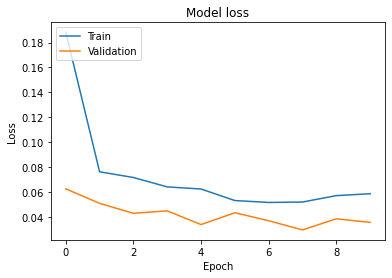

In [80]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [82]:
random_cat = random.choice(os.listdir('images/cats/'))
cat_path = os.path.join('images/cats',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir('images/dogs/'))
dog_path = os.path.join('images/dogs',random_dog)
dog = load_image(dog_path)

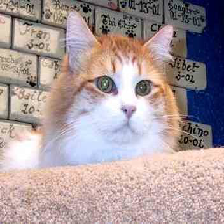

In [83]:
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))

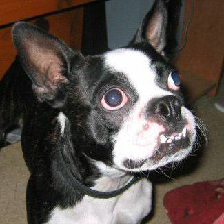

In [84]:
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))

In [85]:
print(f'''cat:{np.round(model.predict(cat),2)}''')

cat:[[1. 0.]]


In [86]:
print(f'''dog:{np.round(model.predict(dog),2)}''')

dog:[[0. 1.]]


In [91]:
tiger_path = 'tiger.jpg'
tiger = load_image(tiger_path)

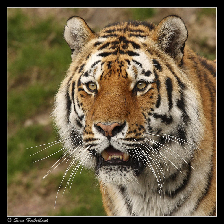

In [93]:
tf.keras.preprocessing.image.load_img(tiger_path, target_size=(224,224))

In [95]:
print(f'''tiger:{np.round(model.predict(tiger),2)}''')

tiger:[[0.51 0.49]]
